In [ ]:
# HelmetGuard – Training ResNet18 on Synthetic + Real Data

#This notebook trains ResNet18 using synthetic data plus a small amount of real training images,
#and compares different training setups (few-shot real, unsafe oversampling) on a real test set.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch

BASE_DIR = "/content/drive/MyDrive/helmetguard"
print("BASE_DIR:", BASE_DIR)


Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/helmetguard


In [ ]:
import torch
from torch import nn
from torchvision import models
from tqdm.auto import tqdm


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset


SYNTH_DIR = os.path.join(BASE_DIR, "data_synth")
REAL_TRAIN_DIR = os.path.join(BASE_DIR, "data_real", "train")

print("SYNTH_DIR:", SYNTH_DIR, "→", os.listdir(SYNTH_DIR))
print("REAL_TRAIN_DIR:", REAL_TRAIN_DIR, "→", os.listdir(REAL_TRAIN_DIR))


train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


synth_full = datasets.ImageFolder(root=SYNTH_DIR, transform=train_transform)
print("Synthetic classes:", synth_full.classes)
print("Total synthetic images:", len(synth_full))


val_ratio = 0.2
val_size = int(len(synth_full) * val_ratio)
train_size = len(synth_full) - val_size

synth_train, synth_val = random_split(synth_full, [train_size, val_size])
synth_val.dataset.transform = val_transform

print("Synthetic train:", len(synth_train))
print("Synthetic val:", len(synth_val))


REAL_TRAIN_DIR = os.path.join(BASE_DIR, "data_real", "train")
real_train = datasets.ImageFolder(root=REAL_TRAIN_DIR, transform=train_transform)
print("Real train classes:", real_train.classes)
print("Real train size:", len(real_train))


SYNTH_DIR: /content/drive/MyDrive/helmetguard/data_synth → ['safe', 'unsafe']
REAL_TRAIN_DIR: /content/drive/MyDrive/helmetguard/data_real/train → ['safe', 'unsafe']
Synthetic classes: ['safe', 'unsafe']
Total synthetic images: 614
Synthetic train: 492
Synthetic val: 122
Real train classes: ['safe', 'unsafe']
Real train size: 35


In [ ]:
from torch.utils.data import ConcatDataset

train_dataset = ConcatDataset([synth_train, real_train])
val_dataset = synth_val  # val נשאר סינתטי בשלב הזה

print("Total train size (synth + real):", len(train_dataset))
print("Val size:", len(val_dataset))


Total train size (synth + real): 527
Val size: 122


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:

try:
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
except:
    model = models.resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

    print(f"Train  Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
    print(f"Val    Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")



Epoch 1/5


  0%|          | 0/17 [00:00<?, ?it/s]

Train  Loss: 0.3384 | Acc: 83.49%
Val    Loss: 0.1361 | Acc: 95.90%

Epoch 2/5


  0%|          | 0/17 [00:00<?, ?it/s]

Train  Loss: 0.0537 | Acc: 98.10%
Val    Loss: 0.1200 | Acc: 94.26%

Epoch 3/5


  0%|          | 0/17 [00:00<?, ?it/s]

Train  Loss: 0.0194 | Acc: 99.43%
Val    Loss: 0.1593 | Acc: 94.26%

Epoch 4/5


  0%|          | 0/17 [00:00<?, ?it/s]

Train  Loss: 0.0108 | Acc: 100.00%
Val    Loss: 0.1448 | Acc: 95.08%

Epoch 5/5


  0%|          | 0/17 [00:00<?, ?it/s]

Train  Loss: 0.0105 | Acc: 99.81%
Val    Loss: 0.1314 | Acc: 95.08%


In [ ]:
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, "resnet18_synth_plus_realtrain.pt")
torch.save(model.state_dict(), model_path)

print("Saved model to:", model_path)


Saved model to: /content/drive/MyDrive/helmetguard/models/resnet18_synth_plus_realtrain.pt


In [ ]:
from torchvision import datasets

REAL_TEST_DIR = os.path.join(BASE_DIR, "data_real", "test")
print("REAL_TEST_DIR:", REAL_TEST_DIR)
print("Folders:", os.listdir(REAL_TEST_DIR))


REAL_TEST_DIR: /content/drive/MyDrive/helmetguard/data_real/test
Folders: ['safe', 'unsafe']


In [ ]:
test_dataset = datasets.ImageFolder(root=REAL_TEST_DIR, transform=val_transform)

print("Test classes:", test_dataset.classes)
print("Test size:", len(test_dataset))


Test classes: ['safe', 'unsafe']
Test size: 44


In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch

@torch.no_grad()
def evaluate_on_loader(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total if total > 0 else 0
    return acc

test_acc = evaluate_on_loader(model, test_loader, device)
print(f"Real test accuracy: {test_acc*100:.2f}%")


Real test accuracy: 52.27%


In [ ]:
from collections import Counter

@torch.no_grad()
def evaluate_per_class(model, loader, device, class_names):
    model.eval()
    correct_per_class = Counter()
    total_per_class = Counter()

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for y, y_pred in zip(labels.cpu().tolist(), preds.cpu().tolist()):
            total_per_class[y] += 1
            if y == y_pred:
                correct_per_class[y] += 1

    for idx, name in enumerate(class_names):
        total = total_per_class[idx]
        correct = correct_per_class[idx]
        acc = correct / total if total > 0 else 0
        print(f"Class '{name}': {correct}/{total} correct ({acc*100:.2f}%)")

evaluate_per_class(model, test_loader, device, test_dataset.classes)


Class 'safe': 17/30 correct (56.67%)
Class 'unsafe': 6/14 correct (42.86%)


In [ ]:

MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, "resnet18_synth_plus_real_oversampled.pt")
torch.save(model.state_dict(), model_path)

print("Saved model to:", model_path)


Saved model to: /content/drive/MyDrive/helmetguard/models/resnet18_synth_plus_real_oversampled.pt


In [ ]:
import torch

def collect_predictions(model, loader, dataset, class_names, device):
    model.eval()
    results = []
    index = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            batch_size = inputs.size(0)
            for i in range(batch_size):
                img_path, _ = dataset.samples[index]  # הנתיב לתמונה
                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                correct = (labels[i].item() == preds[i].item())

                results.append({
                    "path": img_path,
                    "true": true_label,
                    "pred": pred_label,
                    "correct": bool(correct),
                })
                index += 1

    return results

results = collect_predictions(model, test_loader, test_dataset, test_dataset.classes, device)
len(results)


44

In [ ]:
correct_examples = [r for r in results if r["correct"]]
wrong_examples   = [r for r in results if not r["correct"]]

print("Some CORRECT predictions:")
for r in correct_examples[:5]:
    print(f"true={r['true']}, pred={r['pred']}, path={r['path']}")

print("\nSome WRONG predictions:")
for r in wrong_examples[:5]:
    print(f"true={r['true']}, pred={r['pred']}, path={r['path']}")


Some CORRECT predictions:
true=safe, pred=safe, path=/content/drive/MyDrive/helmetguard/data_real/test/safe/images (10).jpeg
true=safe, pred=safe, path=/content/drive/MyDrive/helmetguard/data_real/test/safe/images (11).jpeg
true=safe, pred=safe, path=/content/drive/MyDrive/helmetguard/data_real/test/safe/images (12).jpeg
true=safe, pred=safe, path=/content/drive/MyDrive/helmetguard/data_real/test/safe/images (13).jpeg
true=safe, pred=safe, path=/content/drive/MyDrive/helmetguard/data_real/test/safe/images (17).jpeg

Some WRONG predictions:
true=safe, pred=unsafe, path=/content/drive/MyDrive/helmetguard/data_real/test/safe/Wakecap-smart-helmets.jpg
true=safe, pred=unsafe, path=/content/drive/MyDrive/helmetguard/data_real/test/safe/images (14).jpeg
true=safe, pred=unsafe, path=/content/drive/MyDrive/helmetguard/data_real/test/safe/images (15).jpeg
true=safe, pred=unsafe, path=/content/drive/MyDrive/helmetguard/data_real/test/safe/images (16).jpeg
true=safe, pred=unsafe, path=/content/dri

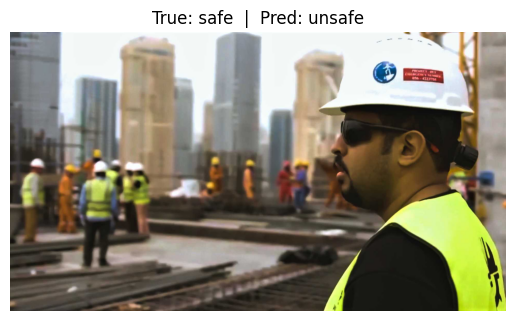

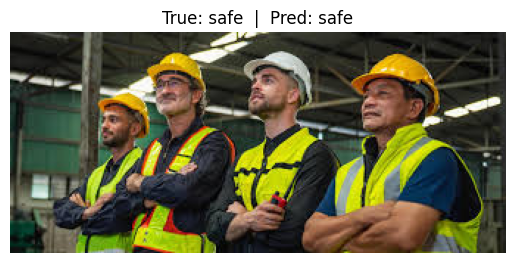

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def show_example(record):
    img = Image.open(record["path"]).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {record['true']}  |  Pred: {record['pred']}")
    plt.show()

show_example(wrong_examples[0])

show_example(correct_examples[0])


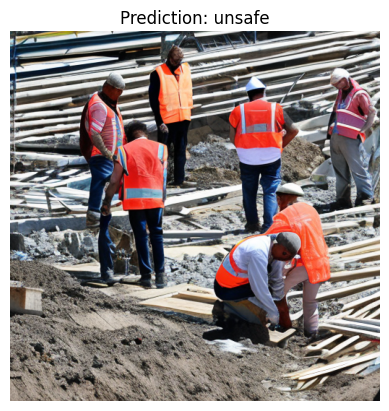

'unsafe'

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(img_path, model, device, transform, class_names):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(x)
        _, pred = torch.max(outputs, 1)
        label = class_names[pred.item()]

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {label}")
    plt.show()

    return label



img_path = "/content/drive/MyDrive/helmetguard/final-test/21.png"
predict_image(img_path, model, device, val_transform, test_dataset.classes)
